# Прогнозирование оттока клиентов в сети отелей «Как в гостях»
# Churn clients from hotel

Описание проекта

Заказчик этого исследования — сеть отелей «Как в гостях». 

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_predict

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from scipy import stats as st
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
#ЗАДАНИЕ КОНСТАНТ



                   #цена номеров разных категорий
                   #вид номера:[за ночь, разовое обслуживание]
PRICE_CATEGORY_ROOM = {
    
    'A':[1000, 400], 
    'B':[800, 350], 
    'C':[600, 350], 
    'D':[550, 150], 
    'E':[500, 150], 
    'F':[450, 150], 
    'G':[350, 150]
}        

PRICE_UP_SP_AU = 1.2 #весной и осенью цены повышаются на 20%
PRICE_UP_SUMM = 1.4 # увеличение цены летом — на 40%

BUDGET_PREDICT = 400e3 #На разработку системы прогнозирования заложен бюджет — 400 000

#число случайности для разных функций и моделей
STATE = 12345


### Шаг 1. Открытие файлов с данными

In [3]:
#чтение двух датасетов
pth1 = 'hotel_train.csv'
pth2 = '/datasets/hotel_train.csv'

if os.path.exists(pth1):
    hotel_train = pd.read_csv(pth1)
elif os.path.exists(pth2):
    hotel_train = pd.read_csv(pth2)
else:
    print('Something is wrong, где-то ошибка, данные не прочитаны')
    
    
pth1 = 'hotel_test.csv'
pth2 = '/datasets/hotel_test.csv'

if os.path.exists(pth1):
    hotel_test = pd.read_csv(pth1)
elif os.path.exists(pth2):
    hotel_test = pd.read_csv(pth2)
else:
    print('Something is wrong, где-то ошибка, данные не прочитаны')


In [4]:
#функция для предварительного изучения таблиц
def what_data(df):
    display('**************************************DATA_OF_TABLE********************************')

    print(' ___________________')
    print('|--------INFO-------|')
    df.info(memory_usage='deep')
    print()
    
    print(' ___________________')
    print('|-------SAMPLE------|')
    display(df.sample(5))
    print()
    
    print('Dublicated_row =',df.duplicated().sum())
    print()
    
    print(' ___________________')
    print('|------DESCRIBE-----|')
    display(df.describe())
    print()

    print(' ___________________')
    print('|----CORRELATION----|')
    display(df.corr())
    print()

    print(' ___________________')
    print('|-----HISTOGRAM-----|')
    df.drop(['id', 
             'arrival_date_month', 
             'arrival_date_week_number', 
             'arrival_date_day_of_month', 
             #'babies', 
             'booking_changes', 
             'country', 
             'customer_type', 
             'distribution_channel', 
             #'is_canceled', 
             'is_repeated_guest', 
             'meal', 
            
            ], axis=1).hist(bins=10, figsize=(8, 6))
    
    

'**************************************DATA_OF_TABLE********************************'

 ___________________
|--------INFO-------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  fl

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
9988,12506,0,14.0,2016,February,6,5,0,2,2.0,...,0,0,0,A,1,0,Contract,1,0,2
1541,1555,0,28.0,2015,October,43,21,0,2,2.0,...,0,0,0,A,0,0,Transient-Party,0,0,2
36520,44460,1,63.0,2016,December,52,18,4,5,2.0,...,0,0,0,A,0,0,Transient,0,2,9
28531,36471,1,163.0,2016,June,24,5,2,2,1.0,...,0,0,0,A,0,0,Transient,0,0,4
4744,4797,1,131.0,2016,August,33,13,2,2,3.0,...,0,0,0,A,0,0,Transient,0,0,4



Dublicated_row = 0

 ___________________
|------DESCRIBE-----|


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000



 ___________________
|----CORRELATION----|


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
id,1.000000,-0.241910,0.004571,0.249393,0.070340,0.009171,-0.094065,-0.157561,0.001824,0.007738,-0.023737,0.002787,-0.003855,0.016588,-0.001738,-0.023523,-0.114431,0.124479,-0.169021
is_canceled,-0.241910,1.000000,0.328142,-0.030835,0.012869,-0.001903,-0.013767,0.010650,0.045153,-0.017746,-0.029589,-0.040242,0.153023,-0.045557,-0.142935,0.075848,-0.186486,-0.257061,0.001542
lead_time,0.004571,0.328142,1.000000,-0.022997,0.091603,-0.010252,0.047003,0.172646,0.119617,-0.056359,-0.024649,-0.089424,0.142454,-0.061690,-0.007191,0.209741,-0.116867,-0.147738,0.157671
arrival_date_year,0.249393,-0.030835,-0.022997,1.000000,-0.388003,0.009789,-0.006474,0.013744,0.029102,0.052613,-0.007381,-0.005957,-0.134027,0.040137,0.041387,0.027224,0.014875,0.089731,0.007535
arrival_date_week_number,0.070340,0.012869,0.091603,-0.388003,1.000000,0.048372,0.034029,0.032295,0.005638,-0.007255,0.003938,-0.013471,0.006870,-0.011915,0.011799,-0.052976,-0.007533,0.076650,0.041886
arrival_date_day_of_month,0.009171,-0.001903,-0.010252,0.009789,0.048372,1.000000,-0.002017,0.003705,0.006034,0.018558,-0.000482,-0.010605,-0.032019,-0.000973,0.022560,0.017070,0.003816,0.005875,0.001898
stays_in_weekend_nights,-0.094065,-0.013767,0.047003,-0.006474,0.034029,-0.002017,1.000000,0.197410,0.116679,0.026224,0.018822,-0.081943,-0.008727,-0.025560,0.023118,-0.065167,-0.015870,0.083682,0.644935
stays_in_week_nights,-0.157561,0.010650,0.172646,0.013744,0.032295,0.003705,0.197410,1.000000,0.119901,0.023590,0.018428,-0.094617,-0.006098,-0.049188,0.061721,0.036037,-0.026988,0.090359,0.876515
adults,0.001824,0.045153,0.119617,0.029102,0.005638,0.006034,0.116679,0.119901,1.000000,-0.003216,0.019756,-0.157053,0.003083,-0.115353,-0.056396,-0.013475,0.013321,0.171793,0.150766
children,0.007738,-0.017746,-0.056359,0.052613,-0.007255,0.018558,0.026224,0.023590,-0.003216,1.000000,0.018410,-0.026707,-0.027357,-0.015807,0.053835,-0.038615,0.047881,0.112699,0.031268



 ___________________
|-----HISTOGRAM-----|


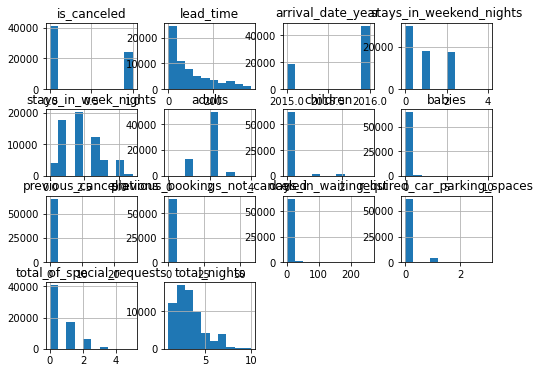

In [5]:
#информация для датасета hotel_train
what_data(hotel_train)

'**************************************DATA_OF_TABLE********************************'

 ___________________
|--------INFO-------|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  fl

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
9678,46867,1,75.0,2017,March,9,4,2,3,4.0,...,0,0,0,G,0,0,Transient,0,1,5
19896,85388,0,20.0,2017,February,6,5,2,2,2.0,...,0,0,0,A,0,0,Transient,0,0,4
9945,47134,1,52.0,2017,March,11,13,1,1,1.0,...,0,0,0,A,0,0,Transient,0,0,2
9810,46999,1,12.0,2017,March,10,10,0,1,2.0,...,0,0,0,A,0,0,Transient,0,0,1
3970,20898,0,70.0,2017,February,8,22,0,4,2.0,...,0,0,0,A,0,0,Transient-Party,1,0,4



Dublicated_row = 0

 ___________________
|------DESCRIBE-----|


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000



 ___________________
|----CORRELATION----|


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
id,1.000000,-0.460092,-0.046589,NaN,0.170086,0.018014,-0.064328,-0.117427,0.032797,-0.015637,-0.011981,-0.099352,-0.018006,-0.035832,0.024081,-0.027058,-0.127872,0.131671,-0.124450
is_canceled,-0.460092,1.000000,0.238844,NaN,0.037331,-0.008966,-0.002269,0.047363,0.077144,0.012774,-0.038884,-0.125657,-0.032993,-0.065467,-0.137758,0.018361,-0.168035,-0.217377,0.036347
lead_time,-0.046589,0.238844,1.000000,NaN,0.344926,0.033666,0.162743,0.290421,0.183892,0.054764,0.002890,-0.169374,-0.058816,-0.089614,0.034083,0.065440,-0.097086,0.030730,0.309580
arrival_date_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,0.170086,0.037331,0.344926,NaN,1.000000,0.124668,0.063705,0.083187,0.119440,0.032536,-0.003458,-0.062687,-0.008091,-0.011487,0.020593,-0.012678,-0.038426,0.063478,0.097063
arrival_date_day_of_month,0.018014,-0.008966,0.033666,NaN,0.124668,1.000000,0.002631,-0.028789,-0.018421,0.005589,-0.003791,0.005226,0.002476,0.007951,-0.001654,-0.005593,0.011347,-0.007256,-0.021478
stays_in_weekend_nights,-0.064328,-0.002269,0.162743,NaN,0.063705,0.002631,1.000000,0.171974,0.102589,0.047861,0.021308,-0.089929,-0.035524,-0.052578,0.013325,0.010750,-0.029331,0.042969,0.626847
stays_in_week_nights,-0.117427,0.047363,0.290421,NaN,0.083187,-0.028789,0.171974,1.000000,0.141751,0.037734,0.030541,-0.115294,-0.036659,-0.058180,0.043919,0.016881,-0.048050,0.035584,0.875336
adults,0.032797,0.077144,0.183892,NaN,0.119440,-0.018421,0.102589,0.141751,1.000000,-0.004425,0.019401,-0.202241,-0.102307,-0.138176,-0.061588,-0.003899,-0.014959,0.121337,0.162469
children,-0.015637,0.012774,0.054764,NaN,0.032536,0.005589,0.047861,0.037734,-0.004425,1.000000,0.026094,-0.029983,-0.015677,-0.020139,0.040325,-0.013518,0.028024,0.068811,0.053336



 ___________________
|-----HISTOGRAM-----|


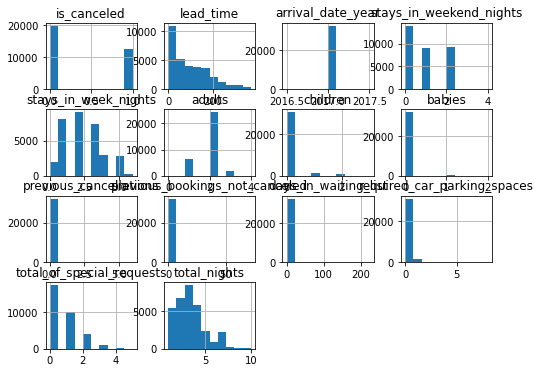

In [6]:
#информация для датасета hotel_test
what_data(hotel_test)

#### Выводы (промежуточные)

Датасет `hotel_train` имеет 65 229 строк и 25 столбцов. Все строки не имеют пропусков, то есть нет Nan.
Столбцы имеют целочисленные значений, значения с плавающей запятой и типа `object`.

Практически все столцы имеют низкую корреляцию друг с другом.

Есть сильная корреляция между столбцами `total_nights` и `stays_in_weekend_nights`, `total_nights` и `stays_in_week_nights`, 0.644935 и 0.876515 соответственно.

Так же есть приличная корреляция между столбцами `previous_bookings_not_canceled` и `is_repeated_guest`, около 0.413. 

Гистограммы столбцов с числовыми данными показывают что распределения данных далеки от нормальных. 

-- --

Датасет `hotel_test` имеет 32 412 строк и 25 столбцов. Строк примерно в два раза меньше чем в обучающем датасете, но количество столбцов совпадает и столбцы имеют те же данные.

Так же, как и в датасете `hotel_train`, все строки не имеют пропусков, и столбцы имеют целочисленные значения, значения с плавающей запятой и типа `object`.

Похожи и коэффициенты корреляций, для тех же столбцов, `total_nights`, `stays_in_weekend_nights`, `total_nights`

Гистограммы столбцов похожи на датасет `hotel_train`

### Шаг 2. Предобработка и исследовательский анализ данных

In [7]:
#проверка что id номера  в одном и другом датасете не совпадают
hotel_train.id.isin(hotel_test.id).sum()

0

In [8]:
#Проверка наличия в датасете hotel_train  одинаковых id
hotel_train.id.nunique()

65229

ВСЕ id уникальны и повторений нет.

In [9]:
#Проверка наличия в датасете hotel_test  одинаковых id
hotel_test.id.nunique()

32412

Так же, все id уникальны и повторений нет.

In [10]:
#список названий столбцов
columns = hotel_train.columns
columns

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'],
      dtype='object')

In [11]:
columns_correct = [
                   'is_canceled', 
                   #'lead_time', 
                   'arrival_date_year',
                   'arrival_date_month', 
                   'stays_in_weekend_nights',
                   'stays_in_week_nights', 
                   'adults', 
                   'children', 
                   'babies', 
                   'meal',
                   'country', 
                   'distribution_channel', 
                   'is_repeated_guest',
                   'previous_cancellations', 
                   'previous_bookings_not_canceled',
                   'reserved_room_type', 
                   'booking_changes', 
                   #'days_in_waiting_list',
                   'customer_type', 
                   'required_car_parking_spaces',
                   'total_of_special_requests', 
                   'total_nights']

In [12]:
#обучающая выборка
#просмотр уникальных значений некоторых столбцов. Цель - дополнительно убедиться что значения корректные.
for j in columns_correct:
    display(j, pd.Series(hotel_train[j].unique()).sort_values())

'is_canceled'

0    0
1    1
dtype: int64

'arrival_date_year'

0    2015
1    2016
dtype: int64

'arrival_date_month'

9         April
1        August
5      December
7      February
6       January
0          July
11         June
8         March
10          May
4      November
3       October
2     September
dtype: object

'stays_in_weekend_nights'

0    0
2    1
1    2
4    3
3    4
dtype: int64

'stays_in_week_nights'

6    0
0    1
1    2
2    3
3    4
4    5
5    6
dtype: int64

'adults'

4    0.0
0    1.0
1    2.0
2    3.0
3    4.0
dtype: float64

'children'

0    0.0
1    1.0
2    2.0
3    3.0
dtype: float64

'babies'

0     0.0
1     1.0
2     2.0
4     9.0
3    10.0
dtype: float64

'meal'

0    BB       
1    FB       
2    HB       
4           SC
3    SC       
dtype: object

'country'

144    ABW
87     AGO
28     ALB
108    AND
49     ARE
      ... 
124    VGB
88     VNM
56     ZAF
112    ZMB
43     ZWE
Length: 155, dtype: object

'distribution_channel'

2    Corporate
0       Direct
3          GDS
1        TA/TO
dtype: object

'is_repeated_guest'

0    0
1    1
dtype: int64

'previous_cancellations'

0      0
1      1
2      2
3      3
9      4
10     5
12     6
14    11
13    13
6     14
8     19
11    21
7     24
5     25
4     26
dtype: int64

'previous_bookings_not_canceled'

0      0
1      1
2      2
3      3
4      4
5      5
6      6
12     7
14     8
13     9
7     10
15    11
8     12
9     13
16    14
10    15
19    16
20    17
17    18
21    19
22    20
11    21
18    22
23    23
24    24
57    25
25    26
26    27
27    28
28    29
29    30
30    31
31    32
32    33
33    34
34    35
35    36
36    37
37    38
38    39
39    40
40    41
41    42
42    43
43    44
44    45
45    47
46    48
47    49
48    50
49    51
50    52
51    53
52    54
53    55
54    56
55    57
56    58
dtype: int64

'reserved_room_type'

0    A               
6    B               
1    C               
2    D               
3    E               
5    F               
4    G               
dtype: object

'booking_changes'

0      0
1      1
3      2
2      3
4      4
5      5
6      6
9      7
12     8
10     9
7     10
11    13
13    14
14    15
8     16
15    17
dtype: int64

'customer_type'

1           Contract
3              Group
0          Transient
2    Transient-Party
dtype: object

'required_car_parking_spaces'

0    0
1    1
2    2
3    3
dtype: int64

'total_of_special_requests'

0    0
1    1
3    2
2    3
4    4
5    5
dtype: int64

'total_nights'

0     1
1     2
2     3
3     4
6     5
4     6
5     7
7     8
9     9
8    10
dtype: int64

In [13]:
#тестовая выборка
#просмотр уникальных значений некоторых столбцов. Цель - дополнительно убедиться что значения корректные.
for j in columns_correct:
    display(j, pd.Series(hotel_test[j].unique()).sort_values())

'is_canceled'

1    0
0    1
dtype: int64

'arrival_date_year'

0    2017
dtype: int64

'arrival_date_month'

3       April
7      August
1    February
0     January
6        July
5        June
2       March
4         May
dtype: object

'stays_in_weekend_nights'

2    0
0    1
1    2
4    3
3    4
dtype: int64

'stays_in_week_nights'

0    0
3    1
1    2
4    3
5    4
2    5
6    6
dtype: int64

'adults'

4    0.0
1    1.0
0    2.0
2    3.0
3    4.0
dtype: float64

'children'

0    0.0
2    1.0
1    2.0
3    3.0
dtype: float64

'babies'

0    0.0
1    1.0
2    2.0
dtype: float64

'meal'

0    BB       
3    FB       
1    HB       
2           SC
4    SC       
dtype: object

'country'

129    ABW
43     AGO
114    ALB
97     AND
33     ARE
      ... 
57     UZB
81     VEN
78     VNM
29     ZAF
112    ZWE
Length: 143, dtype: object

'distribution_channel'

2    Corporate
1       Direct
3          GDS
0        TA/TO
dtype: object

'is_repeated_guest'

0    0
1    1
dtype: int64

'previous_cancellations'

0    0
1    1
2    2
3    3
4    4
5    5
6    6
dtype: int64

'previous_bookings_not_canceled'

0      0
11     1
2      2
1      3
10     4
3      5
4      6
5      7
6      8
12     9
7     10
8     11
9     12
17    13
18    14
23    15
22    16
24    17
25    18
41    19
43    20
44    21
45    22
19    23
20    24
13    25
21    26
14    27
15    28
42    29
16    30
26    58
27    59
28    60
29    61
30    62
31    63
32    64
33    65
34    66
35    67
36    68
37    69
38    70
39    71
40    72
dtype: int64

'reserved_room_type'

0    A               
6    B               
5    C               
3    D               
1    E               
4    F               
2    G               
dtype: object

'booking_changes'

0      0
1      1
2      2
3      3
4      4
6      5
5      6
7      7
12     8
14    10
13    11
11    14
9     15
10    16
8     18
dtype: int64

'customer_type'

2           Contract
3              Group
0          Transient
1    Transient-Party
dtype: object

'required_car_parking_spaces'

0    0
1    1
2    2
4    3
3    8
dtype: int64

'total_of_special_requests'

0    0
1    1
2    2
3    3
4    4
5    5
dtype: int64

'total_nights'

0     1
3     2
6     3
1     4
4     5
5     6
2     7
7     8
8     9
9    10
dtype: int64

In [14]:
hotel_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [15]:
hotel_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [16]:
#удаление пробелов в hotel_train столбец 'meal'
hotel_train['meal'] = hotel_train['meal'].str.strip()

In [17]:
#удаление пробелов в hotel_train столбец 'reserved_room_type'
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip()

In [18]:
hotel_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [19]:
hotel_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [20]:
hotel_test['meal'].unique()

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

In [21]:
hotel_test['reserved_room_type'].unique()

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

In [22]:
#удаление пробелов в hotel_test столбец 'meal'
hotel_test['meal'] = hotel_test['meal'].str.strip()

In [23]:
#удаление пробелов в hotel_test столбец 'reserved_room_type'
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip()

In [24]:
hotel_test['meal'].unique()

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

In [25]:
hotel_test['reserved_room_type'].unique()

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

#### Промежуточные выводы

Оба датасета не имеют "странных" значений во всех столбцах. 

Отличия:

Обучающий - arrival_date_year (год заезда) имеет два значения 2015, 2016.Тестовый - одно значение 2017. Думаю что при подготовки данных для обучения модели эти столбцы необходимо удалить. И возможно стоит удалить столбцы с месяцем, неделей и днем.

Обучающий - babies максимум 10 младенцев.Тестовый - babies максимум 2 младенца.

Обучающий - required_car_parking_spaces три значение 0, 1, 2 и 3.Тестовый - required_car_parking_spaces большое число требуемых парковочных мест 0, 1, 2, 3 и странное значение 8.



In [26]:
#проверка количества записей с большим числом младенцев 
hotel_train.sort_values(by='babies', ascending=False).babies.head(10)

22995    10.0
41528     9.0
7390      2.0
15516     2.0
56050     2.0
3720      1.0
8942      1.0
22960     1.0
4846      1.0
10878     1.0
Name: babies, dtype: float64

Таких строк всего две. Считаю что их можно удалить.

In [27]:
#удаление строк с числом младенцев больше 2-х. Остаются только строки с 0 и 1.
hotel_train = hotel_train.query('babies < 2')

In [28]:
#проверка 
hotel_train.sort_values(by='babies', ascending=False).babies

24543    1.0
9991     1.0
8942     1.0
22960    1.0
9976     1.0
        ... 
21909    0.0
21910    0.0
21911    0.0
21912    0.0
65228    0.0
Name: babies, Length: 65224, dtype: float64

In [29]:
#проверка количества записей парковочных мест required_car_parking_spaces
hotel_train.sort_values(by='required_car_parking_spaces', ascending=False).required_car_parking_spaces.head(10)

64080    3
55756    2
4072     2
12736    2
12144    2
7373     2
13782    2
11339    2
14204    2
1568     2
Name: required_car_parking_spaces, dtype: int64

Есть только одна запись с 3-мя парковочными местами. Принимаю решения такую строку удалить.

In [30]:
hotel_train = hotel_train.query('required_car_parking_spaces < 3')

In [31]:
#проверка 
hotel_train.sort_values(by='required_car_parking_spaces', ascending=False).required_car_parking_spaces

10933    2
11339    2
12144    2
12736    2
13782    2
        ..
23396    0
23397    0
23398    0
23399    0
65228    0
Name: required_car_parking_spaces, Length: 65223, dtype: int64

<b>Датасет<b>
    
`hotel_test`

In [32]:
#проверка количества записей с большим числом младенцев 
hotel_test.sort_values(by='babies', ascending=False).babies.head(10)

22193    2.0
7535     2.0
18827    2.0
3812     2.0
18756    1.0
3616     1.0
18795    1.0
8696     1.0
6572     1.0
5675     1.0
Name: babies, dtype: float64

Всего 4 строки с количеством младенцев равным 2. Принимаю решение удалить эти строки.

In [33]:
#удаление строк с числом младенцев больше 2-х. Остаются только строки с 0 и 1.
hotel_test = hotel_test.query('babies < 2')

In [34]:
#проверка 
hotel_test.sort_values(by='babies', ascending=False).babies

2065     1.0
18756    1.0
18795    1.0
6598     1.0
3616     1.0
        ... 
10851    0.0
10850    0.0
10849    0.0
10848    0.0
32411    0.0
Name: babies, Length: 32408, dtype: float64

In [35]:
#проверка количества строк требуемых парковочных мест required_car_parking_spaces равными 8. В тестовой выборке
#возможно у этих людей много детей?
hotel_test.query('required_car_parking_spaces == 8')[['babies', 'children']]

,babies,children
2549,0.0,0.0
2550,0.0,0.0


In [36]:
#проверка количества записей с парковочными местами 
hotel_test.sort_values(by='required_car_parking_spaces', ascending=False).required_car_parking_spaces.head(15)

2550     8
2549     8
25031    3
3248     2
3247     2
2502     2
3277     2
4197     2
2813     2
6650     1
6657     1
2624     1
6654     1
2628     1
6651     1
Name: required_car_parking_spaces, dtype: int64

В  датасете `` также строк, с парковочными местами 3 и более, всего 3 штуки. Принимаю решение такие строки удалить.

In [37]:
#удаление строк с числом парковок больше 2-х. Остаются только строки с 0,1,2 парковки.
hotel_test = hotel_test.query('required_car_parking_spaces <= 2')

In [38]:
#проверка 
hotel_test.sort_values(by='required_car_parking_spaces', ascending=False).required_car_parking_spaces

3247     2
2813     2
2502     2
3277     2
4197     2
        ..
11469    0
11468    0
11467    0
11466    0
32411    0
Name: required_car_parking_spaces, Length: 32405, dtype: int64

In [39]:
#доп проверка
hotel_test['required_car_parking_spaces'].unique()

array([0, 1, 2])

In [40]:
#проверка сбалансированности целевого признака обучающей выборки
hotel_train.is_canceled.mean()

0.3686429633718167

In [41]:
#проверка сбалансированности целевого признака тестовой выборки
hotel_test.is_canceled.mean()

0.3885511495139639

Примерно 37% и 39%. Дисбалланс не сильный.

<b> Дополнительное исследование некоторых столбцов

In [42]:
#доля клиентов по странам hotel_train
hotel_train['country'].value_counts(normalize=True).head(5)

PRT    0.442007
FRA    0.091593
GBR    0.078301
ESP    0.075127
DEU    0.059596
Name: country, dtype: float64

44% клиентов из страны PRT (видимо Португалия), 9% - FRA и 7,8% - GBR.

In [43]:
#доля клиентов по странам hotel_test
hotel_test.country.value_counts(normalize=True).head(5)

PRT    0.304984
GBR    0.121185
FRA    0.107298
DEU    0.073384
ESP    0.059590
Name: country, dtype: float64

Похожее распределение. На первом месте клиенты из страны PRT

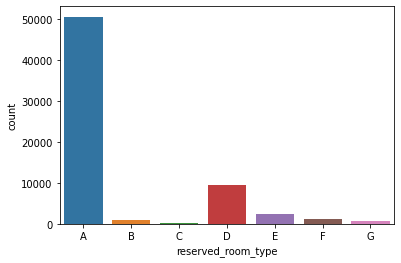

In [44]:
#распределение по типу номера для hotel_train
sns.countplot(x=hotel_train['reserved_room_type'].sort_values())
None

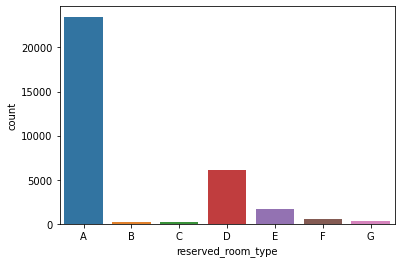

In [45]:
#распределение по типу номера для hotel_test
sns.countplot(x=hotel_test['reserved_room_type'].sort_values())
None

В двух датасетах распределения очень похожи друг на друга.

Чаще всего снимают номер категории А, на втором месте категория D, на третьем - Е.

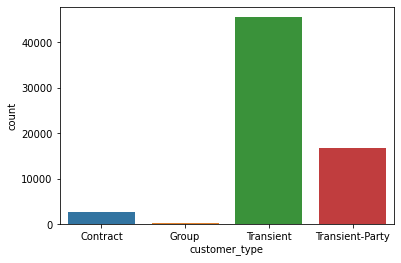

In [46]:
#распределение customer_type для hotel_train
sns.countplot(x=hotel_train['customer_type'].sort_values())
None

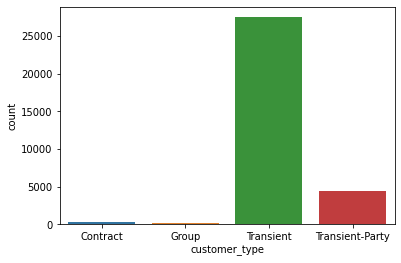

In [47]:
#распределение customer_type для hotel_test
sns.countplot(x=hotel_test['customer_type'].sort_values())
None

Так же графики качественно похожи друг на друга. На первом месте клиенты `Transient`, на втором `Transient-party`

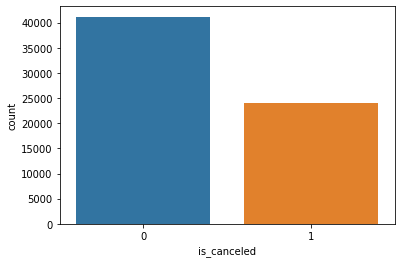

In [48]:
#распределение по is_canceled для hotel_train
sns.countplot(x=hotel_train['is_canceled'].sort_values())
None

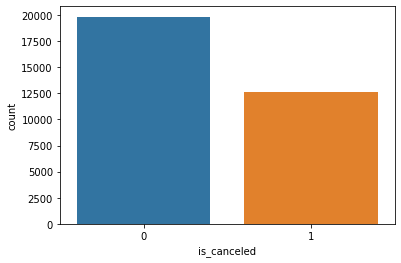

In [49]:
#распределение по is_canceled для hotel_test
sns.countplot(x=hotel_test['is_canceled'].sort_values())
None

Распределения похожи. Довольно много клиентов отменяют заказ.

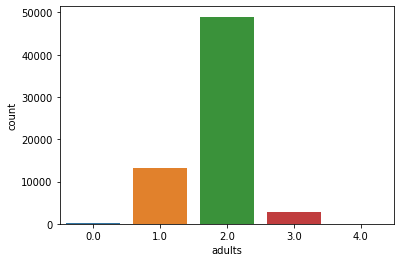

In [50]:
#распределение по adults для hotel_train
sns.countplot(x=hotel_train['adults'].sort_values())
None

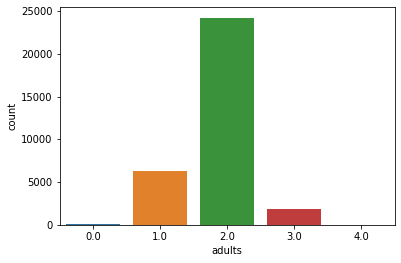

In [51]:
#распределение по adults для hotel_test
sns.countplot(x=hotel_test['adults'].sort_values())
None

По количеству взрослых постояльцев так же совпадения между датасетами. 

Чаще всего два взрослых, потом 1 и 3 взрослых постояльца.

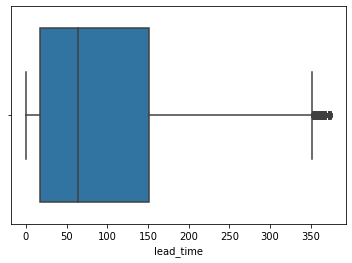

In [52]:
#диаграмма размаха lead_time для hotel_train
sns.boxplot(x=hotel_train['lead_time'])
None

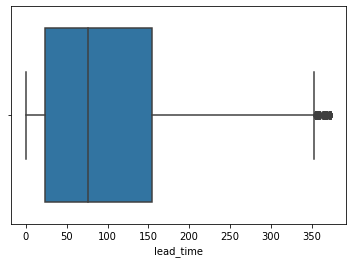

In [53]:
#диаграмма размаха lead_time для hotel_test
sns.boxplot(x=hotel_test['lead_time'])
None

(количество дней между датой бронирования и датой прибытия)
Медиана немного отличается. Расстояние между первым и третьим квартилем одинаково.

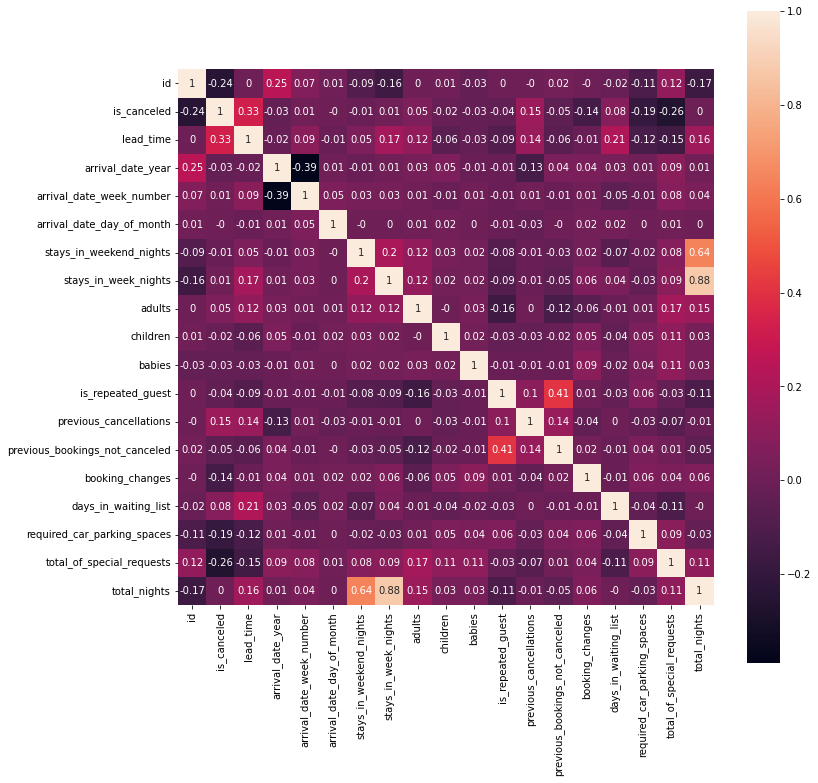

In [54]:
#heatmap для матрицы корреляций для hotel_train
plt.figure(figsize = (12,12))
sns.heatmap(hotel_train.corr().round(2), annot=True, square=True)
None

На heatmap корреляции хорошо видна сильная связь между столбцами total_nights и stays_in_weekend_nights, stays_in_week_nights. 

Значит стоит проверить что, общее количество ночей = количество ночей в будние дни + количество ночей в выходные дни

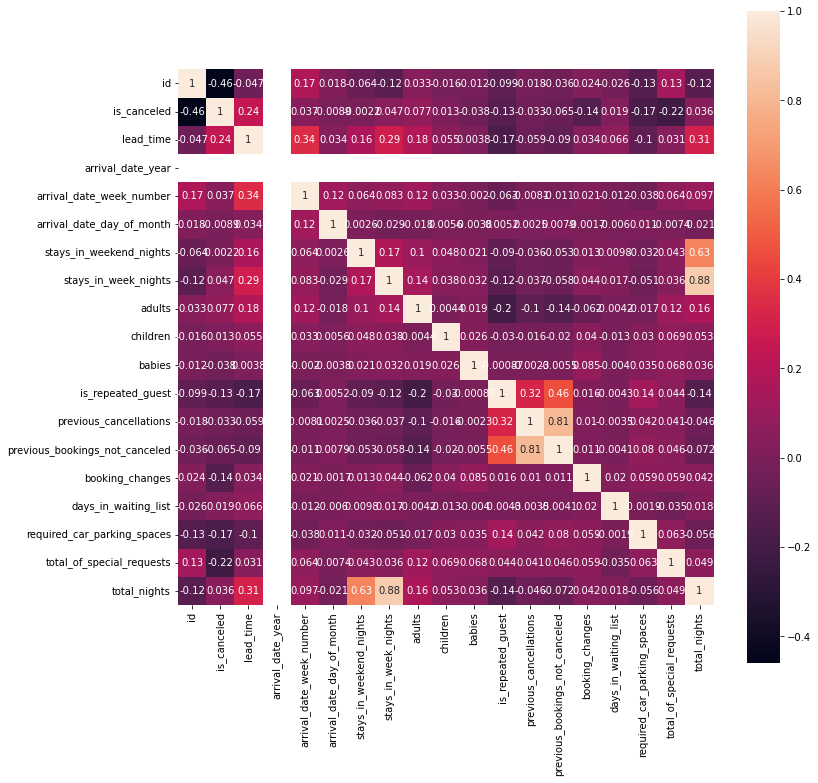

In [55]:
#heatmap для матрицы корреляций для hotel_test
plt.figure(figsize = (12,12))
sns.heatmap(hotel_test.corr(), annot=True, square=True)
None

Для датасета hotel_test ситуация аналогичная.

Проверка отсутствия дубликатов строк без столбца id, датасет hotel_train

In [56]:
#удаление столбца id
hotel_train = hotel_train.drop('id', axis=1)

In [57]:
hotel_train.duplicated().sum()

21377

Дубликатов слишком много, примерно третья часть

In [58]:
#удаление дубликатов строк
hotel_train = hotel_train.drop_duplicates().reset_index()

In [59]:
hotel_train.duplicated().sum()

0

In [60]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43846 entries, 0 to 43845
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           43846 non-null  int64  
 1   is_canceled                     43846 non-null  int64  
 2   lead_time                       43846 non-null  float64
 3   arrival_date_year               43846 non-null  int64  
 4   arrival_date_month              43846 non-null  object 
 5   arrival_date_week_number        43846 non-null  int64  
 6   arrival_date_day_of_month       43846 non-null  int64  
 7   stays_in_weekend_nights         43846 non-null  int64  
 8   stays_in_week_nights            43846 non-null  int64  
 9   adults                          43846 non-null  float64
 10  children                        43846 non-null  float64
 11  babies                          43846 non-null  float64
 12  meal                            

In [61]:
#Проверка соотношения классов
hotel_train.is_canceled.mean()

0.2542535236965744

После этой обработки соотношение классов сильно изменилось.

Проверка отсутствия дубликатов строк без столбца id, датасет hotel_test

In [62]:
#удаление столбца id, датасет hotel_test
hotel_test = hotel_test.drop('id', axis=1)

In [63]:
hotel_test.duplicated().sum()

7717

дубликатов так же крайне много, около четверти от всех записей.

In [64]:
#удаление дубликатов строк
hotel_test = hotel_test.drop_duplicates().reset_index()

In [65]:
hotel_test.duplicated().sum()

0

In [66]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24688 entries, 0 to 24687
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           24688 non-null  int64  
 1   is_canceled                     24688 non-null  int64  
 2   lead_time                       24688 non-null  float64
 3   arrival_date_year               24688 non-null  int64  
 4   arrival_date_month              24688 non-null  object 
 5   arrival_date_week_number        24688 non-null  int64  
 6   arrival_date_day_of_month       24688 non-null  int64  
 7   stays_in_weekend_nights         24688 non-null  int64  
 8   stays_in_week_nights            24688 non-null  int64  
 9   adults                          24688 non-null  float64
 10  children                        24688 non-null  float64
 11  babies                          24688 non-null  float64
 12  meal                            

In [67]:
#проверка отношения классов после удаления дубликатов
hotel_test.is_canceled.mean()

0.3153353856124433

Отношение классов так же сильно изменилось.

<b>Проверка количества строк с количеством взрослых равным нулю.

Проверка количества строк с количеством взрослых равным нулю. Датасет hotel_train

In [68]:
hotel_train.query('adults == 0').children.describe()

count    164.000000
mean       1.853659
std        0.638671
min        0.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: children, dtype: float64

Проверка количества строк с количеством взрослых равным нулю. Датасет hotel_test

In [69]:
hotel_test.query('adults == 0').children.describe()

count    65.000000
mean      1.784615
std       0.672967
min       0.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       3.000000
Name: children, dtype: float64

В обоих датасетах таких строк менее 0,4%. Можно заменить нулевые значения на медиану. Но сильного влияния эти строки не окажут, поэтому принимаю решение их удалить.

In [70]:
#удаление строк с количеством взрослых равным нулю
hotel_train = hotel_train.query('adults != 0')

In [71]:
#проверка
hotel_train.query('adults == 0')

,index,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


In [72]:
#удаление строк с количеством взрослых равным нулю
hotel_test = hotel_test.query('adults != 0')

In [73]:
#проверка
hotel_test.query('adults == 0')

,index,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


Проверка что `total_nights` = `stays_in_week_nights` + `stays_in_weekend_nights`

In [74]:
(hotel_train.total_nights == hotel_train.stays_in_week_nights + hotel_train.stays_in_weekend_nights).min()

True

In [75]:
(hotel_test.total_nights == hotel_test.stays_in_week_nights + hotel_test.stays_in_weekend_nights).min()

True

Да, столбец `total_nights` это и есть сумма столбцов `stays_in_week_nights` и `stays_in_weekend_nights`

Принимаю решение удалить столбец `stays_in_weekend_nights` в обоих датасетах

In [76]:
hotel_train = hotel_train.drop('stays_in_weekend_nights', axis=1)

In [77]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43682 entries, 0 to 43845
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           43682 non-null  int64  
 1   is_canceled                     43682 non-null  int64  
 2   lead_time                       43682 non-null  float64
 3   arrival_date_year               43682 non-null  int64  
 4   arrival_date_month              43682 non-null  object 
 5   arrival_date_week_number        43682 non-null  int64  
 6   arrival_date_day_of_month       43682 non-null  int64  
 7   stays_in_week_nights            43682 non-null  int64  
 8   adults                          43682 non-null  float64
 9   children                        43682 non-null  float64
 10  babies                          43682 non-null  float64
 11  meal                            43682 non-null  object 
 12  country                         

In [78]:
hotel_test = hotel_test.drop('stays_in_weekend_nights', axis=1)

In [79]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24623 entries, 0 to 24687
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           24623 non-null  int64  
 1   is_canceled                     24623 non-null  int64  
 2   lead_time                       24623 non-null  float64
 3   arrival_date_year               24623 non-null  int64  
 4   arrival_date_month              24623 non-null  object 
 5   arrival_date_week_number        24623 non-null  int64  
 6   arrival_date_day_of_month       24623 non-null  int64  
 7   stays_in_week_nights            24623 non-null  int64  
 8   adults                          24623 non-null  float64
 9   children                        24623 non-null  float64
 10  babies                          24623 non-null  float64
 11  meal                            24623 non-null  object 
 12  country                         

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Так как основная бизнес метрика это непосредственно прибыль отеля, следовательно необходимо подготовить датасет так, чтобы кроме целевого признака иметь ещё и прибыль.


Расчет прибыли отеля

In [80]:
hotel_train.arrival_date_month.unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [81]:
#функция расчета прибыли отеля
def revenue_hotel(row):
    
    #если месяц снятия номера весна или осень, то сезонный коэффициент (season_coeff) равен константе
    if row['arrival_date_month'] in ['September', 'October', 'November', 'March', 'April', 'May']:
        season_coeff = PRICE_UP_SP_AU
    
    #если месяц снятия номера лето, то сезонный коэффициент (season_coeff) равен летней константе
    if row['arrival_date_month'] in ['June', 'July', 'August']:
        season_coeff = PRICE_UP_SUMM
    #иначе, если месяц снятия зимний, то сезонный коэффициент (season_coeff) равен единице
    else:
        season_coeff = 1
        
    price_room = PRICE_CATEGORY_ROOM[row['reserved_room_type']][0] #цена номера соответствующей категории
    cleaning_room = PRICE_CATEGORY_ROOM[row['reserved_room_type']][1] #цена уборки
    
    #если клиент отменил заказ, возвращаем отрицательную прибыль, то есть убыток
    if row['is_canceled'] == 1:
        #убыток (отрицательная прибыль) = цена комнаты * сезонный коэффициент + цена уборки номера
        revenue = - (price_room * season_coeff + cleaning_room)
        return revenue
    
    #количество уборок
    #одна уборка перед заселением + чётное количество уборок
    n_cleaning_room = 1 + row['total_nights'] // 2 
    
    #прибыль = количество ночей * цена номера * сезонный коэффициент минус цена уборки * количество уборок
    revenue = row['total_nights'] * price_room * season_coeff - cleaning_room * n_cleaning_room
    
    return revenue

In [82]:
hotel_train.loc[3:5]

,index,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
3,3,0,9.0,2015,July,27,1,2,2.0,0.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,3,2.0,0.0,...,0,0,0,A,0,0,Transient,0,1,3
5,5,1,75.0,2015,July,27,1,3,2.0,0.0,...,0,0,0,D,0,0,Transient,0,0,3


In [83]:
#проверка функции на случайных строках
revenue_hotel(hotel_train.loc[5])

-920.0

In [84]:
#проверка функции на случайных строках
revenue_hotel(hotel_train.loc[3])

980.0

#### Добавление в оба датасета прибыли отеля

In [85]:
def add_revenue_test(df):
    df['revenue_hotel'] = df.apply(revenue_hotel, axis=1)
    display(df.sample(3))
    print()
    print('Строки с нулевой прибылью')
    display(df.query('revenue_hotel == 0'))
    df.revenue_hotel.hist(bins=20, figsize=(4, 2))
    #подписи к осям 
    #plt.xlabel('Предсказанная добыча, тыс.баррелей')
    #plt.ylabel('Количество скважин')

    #заголовок к графику
    plt.title('Гистограмма прибыли')
    plt.show()
    
    
    print('Убыль = ', df.query('revenue_hotel < 0').revenue_hotel.sum()/1e6, 'млн')
    print('Прибыль', df.query('revenue_hotel > 0').revenue_hotel.sum()/1e6, 'млн')

,index,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,revenue_hotel
35755,55360,0,112.0,2016,July,30,17,2,2.0,0.0,...,0,0,A,0,0,Transient,0,1,4,4400.0
4361,6108,0,24.0,2016,November,47,14,1,1.0,0.0,...,1,7,A,1,0,Transient,1,0,2,1200.0
42312,63429,0,11.0,2016,November,48,21,1,1.0,0.0,...,0,0,E,1,0,Transient,0,0,2,700.0



Строки с нулевой прибылью


,index,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,revenue_hotel


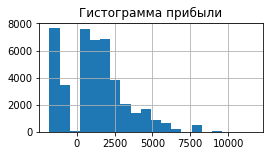

Убыль =  -14.1082 млн
Прибыль 71.7179 млн


In [86]:
#датасет hotel_train
add_revenue_test(hotel_train)

,index,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,revenue_hotel
16017,22128,0,44.0,2017,March,11,15,3,2.0,0.0,...,0,0,A,0,0,Transient,0,0,3,2200.0
15981,22090,0,73.0,2017,March,11,12,3,2.0,0.0,...,0,0,A,0,0,Transient,0,2,5,3800.0
3243,3872,0,0.0,2017,February,8,20,1,2.0,0.0,...,0,0,C,0,0,Transient,0,0,2,500.0



Строки с нулевой прибылью


,index,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,revenue_hotel


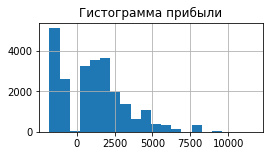

Убыль =  -10.0032 млн
Прибыль 39.38381 млн


In [87]:
#датасет hotel_test
add_revenue_test(hotel_test)

В обоих датасетах прибыль превышает убытки.

### Шаг 4. Разработка модели ML

In [88]:
#проверка строк не совпадающих по столбцу country между датасетами
hotel_train[~hotel_train.country.isin(hotel_test.country)]

,index,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,revenue_hotel
283,297,0,91.0,2015,July,29,17,2,2.0,1.0,...,0,0,A,3,0,Transient,0,3,3,3400.0
830,879,0,154.0,2015,September,36,3,3,2.0,0.0,...,0,0,A,0,0,Transient-Party,0,0,3,2200.0
1423,1558,0,92.0,2015,October,43,22,3,2.0,0.0,...,0,0,A,0,0,Transient-Party,0,2,4,2800.0
4140,5866,1,16.0,2016,December,50,8,1,1.0,0.0,...,0,0,A,0,0,Transient-Party,0,0,1,-1400.0
6321,8713,0,15.0,2015,November,47,21,5,2.0,0.0,...,0,0,D,0,0,Transient,0,0,7,3250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42409,63548,0,215.0,2016,November,48,21,2,1.0,0.0,...,0,0,A,2,0,Transient,0,1,3,2200.0
42412,63551,0,215.0,2016,November,48,21,2,1.0,0.0,...,0,0,A,0,0,Transient,0,0,3,2200.0
42416,63555,0,215.0,2016,November,48,21,2,1.0,0.0,...,0,0,A,0,0,Transient,0,1,3,2200.0
42417,63556,0,215.0,2016,November,48,21,2,1.0,0.0,...,0,0,A,2,0,Transient,0,0,3,2200.0


In [89]:
#оставление только тех строк которые есть в датасете hotel_test
hotel_train = hotel_train[hotel_train.country.isin(hotel_test.country)]

In [90]:
#проверка
hotel_train[~hotel_train.country.isin(hotel_test.country)]

,index,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,revenue_hotel


In [91]:
#проверка строк не совпадающих по столбцу country между датасетами
hotel_test[~hotel_test.country.isin(hotel_train.country)]

,index,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,revenue_hotel
986,1327,1,322.0,2017,May,22,31,3,2.0,2.0,...,0,0,G,0,0,Transient,0,0,3,-500.0
2297,2747,0,0.0,2017,January,2,8,0,2.0,0.0,...,0,0,A,0,0,Transient,0,0,1,600.0
3019,3619,0,1.0,2017,February,7,14,1,1.0,0.0,...,0,0,A,0,0,Transient-Party,0,1,1,600.0
4015,4820,0,3.0,2017,April,14,2,1,2.0,0.0,...,0,0,A,0,0,Transient,0,1,3,2200.0
4697,5616,0,159.0,2017,April,17,29,5,2.0,0.0,...,0,0,D,0,0,Contract,0,0,7,3250.0
9714,13321,1,11.0,2017,May,20,15,2,2.0,0.0,...,0,0,E,0,0,Transient,0,1,3,-650.0
10803,15757,1,200.0,2017,June,26,25,0,2.0,0.0,...,0,0,A,0,0,Transient,0,1,2,-1800.0
13156,18637,0,1.0,2017,January,1,5,2,2.0,0.0,...,0,0,A,1,0,Transient,0,0,2,1200.0
13401,18939,0,44.0,2017,January,2,9,4,2.0,0.0,...,0,0,A,0,0,Transient,0,1,5,3800.0
13781,19407,0,89.0,2017,January,4,25,1,2.0,0.0,...,0,0,A,0,0,Transient,0,1,1,600.0


In [92]:
#оставление только тех строк которые есть в датасете hotel_train
hotel_test = hotel_test[hotel_test.country.isin(hotel_train.country)]

In [93]:
#проверка
hotel_test[~hotel_test.country.isin(hotel_train.country)]

,index,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,revenue_hotel


In [94]:
sorted(hotel_train.country.unique())

['ABW',
 'AGO',
 'ALB',
 'AND',
 'ARE',
 'ARG',
 'ATA',
 'AUS',
 'AUT',
 'AZE',
 'BEL',
 'BEN',
 'BGD',
 'BGR',
 'BHR',
 'BIH',
 'BLR',
 'BRA',
 'CHE',
 'CHL',
 'CHN',
 'CIV',
 'CMR',
 'CN',
 'COL',
 'CPV',
 'CRI',
 'CUB',
 'CYP',
 'CZE',
 'DEU',
 'DNK',
 'DOM',
 'DZA',
 'ECU',
 'EGY',
 'ESP',
 'EST',
 'ETH',
 'FIN',
 'FRA',
 'GAB',
 'GBR',
 'GIB',
 'GNB',
 'GRC',
 'HKG',
 'HRV',
 'HUN',
 'IDN',
 'IMN',
 'IND',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JEY',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KOR',
 'KWT',
 'LBN',
 'LBY',
 'LIE',
 'LKA',
 'LTU',
 'LUX',
 'LVA',
 'MAC',
 'MAR',
 'MCO',
 'MDV',
 'MEX',
 'MLT',
 'MNE',
 'MOZ',
 'MUS',
 'MYS',
 'NGA',
 'NLD',
 'NOR',
 'NZL',
 'PAK',
 'PAN',
 'PER',
 'PHL',
 'POL',
 'PRI',
 'PRT',
 'PRY',
 'QAT',
 'ROU',
 'RUS',
 'SAU',
 'SEN',
 'SGP',
 'SLV',
 'SRB',
 'STP',
 'SUR',
 'SVK',
 'SVN',
 'SWE',
 'SYC',
 'SYR',
 'THA',
 'TJK',
 'TUN',
 'TUR',
 'TWN',
 'TZA',
 'UKR',
 'URY',
 'USA',
 'UZB',
 'VEN',
 'VNM',
 'ZAF',
 'ZWE']

In [95]:
sorted(hotel_test.country.unique())

['ABW',
 'AGO',
 'ALB',
 'AND',
 'ARE',
 'ARG',
 'ATA',
 'AUS',
 'AUT',
 'AZE',
 'BEL',
 'BEN',
 'BGD',
 'BGR',
 'BHR',
 'BIH',
 'BLR',
 'BRA',
 'CHE',
 'CHL',
 'CHN',
 'CIV',
 'CMR',
 'CN',
 'COL',
 'CPV',
 'CRI',
 'CUB',
 'CYP',
 'CZE',
 'DEU',
 'DNK',
 'DOM',
 'DZA',
 'ECU',
 'EGY',
 'ESP',
 'EST',
 'ETH',
 'FIN',
 'FRA',
 'GAB',
 'GBR',
 'GIB',
 'GNB',
 'GRC',
 'HKG',
 'HRV',
 'HUN',
 'IDN',
 'IMN',
 'IND',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JEY',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KOR',
 'KWT',
 'LBN',
 'LBY',
 'LIE',
 'LKA',
 'LTU',
 'LUX',
 'LVA',
 'MAC',
 'MAR',
 'MCO',
 'MDV',
 'MEX',
 'MLT',
 'MNE',
 'MOZ',
 'MUS',
 'MYS',
 'NGA',
 'NLD',
 'NOR',
 'NZL',
 'PAK',
 'PAN',
 'PER',
 'PHL',
 'POL',
 'PRI',
 'PRT',
 'PRY',
 'QAT',
 'ROU',
 'RUS',
 'SAU',
 'SEN',
 'SGP',
 'SLV',
 'SRB',
 'STP',
 'SUR',
 'SVK',
 'SVN',
 'SWE',
 'SYC',
 'SYR',
 'THA',
 'TJK',
 'TUN',
 'TUR',
 'TWN',
 'TZA',
 'UKR',
 'URY',
 'USA',
 'UZB',
 'VEN',
 'VNM',
 'ZAF',
 'ZWE']

Таким образом в датасетах не осталось строк имеющих различные категории по столбцу `country`

In [96]:
#Удаление столбцов не учавствующих в обучении и проверке моделей hotel_train
hotel_train = hotel_train.drop(['index', 
                                'arrival_date_year', 
                                'arrival_date_month', 
                                'arrival_date_week_number', 
                                'arrival_date_day_of_month', 
                                #'revenue_hotel'
                             
                            ] , axis=1)

In [97]:
#Удаление столбцов не учавствующих в обучении и проверке моделей hotel_test
hotel_test = hotel_test.drop(['index', 
                                'arrival_date_year', 
                                'arrival_date_month', 
                                'arrival_date_week_number', 
                                'arrival_date_day_of_month', 
                                #'revenue_hotel'
                             
                            ] , axis=1)

<b>Преобразование датасетов техникой прямого кодирования `One-Hot Encoding` для модели `LogisticRegression`

In [98]:
hotel_train_ohe = pd.get_dummies(hotel_train, drop_first=True)

In [99]:
hotel_test_ohe = pd.get_dummies(hotel_test, drop_first=True)

In [100]:
#проверка
hotel_train_ohe

,is_canceled,lead_time,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,7.0,1,1.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,14.0,2,2.0,0.0,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0.0,2,2.0,0.0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,9.0,2,2.0,0.0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,1,85.0,3,2.0,0.0,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43841,0,23.0,4,2.0,0.0,0.0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
43842,0,53.0,3,2.0,0.0,0.0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
43843,0,7.0,4,2.0,0.0,0.0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
43844,0,17.0,5,2.0,0.0,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [101]:
#проверка
hotel_test_ohe

,is_canceled,lead_time,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,74.0,0,2.0,0.0,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,62.0,2,2.0,0.0,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,1,71.0,2,1.0,0.0,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,1,172.0,5,2.0,0.0,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,52.0,5,1.0,0.0,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24683,0,164.0,4,2.0,0.0,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
24684,0,21.0,5,2.0,0.0,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
24685,0,23.0,5,2.0,0.0,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
24686,0,34.0,5,2.0,0.0,0.0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0


In [102]:
#отделение целевого признака hotel_train_ohe
train_target_ohe = hotel_train_ohe['is_canceled']

In [103]:
#отделение признаков на обучающую выборку hotel_train_ohe
train_features_ohe = hotel_train_ohe.drop(['is_canceled', 'revenue_hotel'] , axis=1)

In [104]:
train_target_ohe.shape

(43618,)

In [105]:
train_features_ohe.shape

(43618, 151)

In [106]:
#отделение целевого признака hotel_train_ohe
test_target_ohe = hotel_test_ohe['is_canceled']

In [107]:
#отделение признаков на обучающую выборку hotel_train_ohe
test_features_ohe = hotel_test_ohe.drop(['is_canceled', 'revenue_hotel'] , axis=1)

In [108]:
test_target_ohe.shape

(24599,)

In [109]:
test_features_ohe.shape

(24599, 151)

<b>Преобразование датасетов техникой `OrdinalEncoder` для моделей `DecisionTreeClassifier` и `RandomForestClassifier`

In [110]:
hotel_train.reserved_room_type.unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [111]:
#колонки для преобразования по OrdinalEncoder
columns_oe = [
    'reserved_room_type', 
    'customer_type', 
    'meal', 
    'country', 
    'distribution_channel'
]

In [112]:
#Создаём объект этой структуры данных
encoder = OrdinalEncoder()

In [113]:
#обучение модели на обучающей выборке hotel_train
encoder.fit(hotel_train[columns_oe])

OrdinalEncoder()

In [114]:
#преобразование категориальных столбцов hotel_test
hotel_test[columns_oe] = encoder.transform(hotel_test[columns_oe])

In [115]:
#преобразование категориальных столбцов hotel_train
hotel_train[columns_oe] = encoder.transform(hotel_train[columns_oe])

In [116]:
#проверка
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43618 entries, 0 to 43845
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     43618 non-null  int64  
 1   lead_time                       43618 non-null  float64
 2   stays_in_week_nights            43618 non-null  int64  
 3   adults                          43618 non-null  float64
 4   children                        43618 non-null  float64
 5   babies                          43618 non-null  float64
 6   meal                            43618 non-null  float64
 7   country                         43618 non-null  float64
 8   distribution_channel            43618 non-null  float64
 9   is_repeated_guest               43618 non-null  int64  
 10  previous_cancellations          43618 non-null  int64  
 11  previous_bookings_not_canceled  43618 non-null  int64  
 12  reserved_room_type              

In [117]:
#проверка
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24599 entries, 0 to 24687
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     24599 non-null  int64  
 1   lead_time                       24599 non-null  float64
 2   stays_in_week_nights            24599 non-null  int64  
 3   adults                          24599 non-null  float64
 4   children                        24599 non-null  float64
 5   babies                          24599 non-null  float64
 6   meal                            24599 non-null  float64
 7   country                         24599 non-null  float64
 8   distribution_channel            24599 non-null  float64
 9   is_repeated_guest               24599 non-null  int64  
 10  previous_cancellations          24599 non-null  int64  
 11  previous_bookings_not_canceled  24599 non-null  int64  
 12  reserved_room_type              

In [118]:
hotel_train.reserved_room_type.unique()

array([0., 2., 3., 4., 6., 5., 1.])

In [119]:
hotel_test.reserved_room_type.unique()

array([0., 4., 6., 3., 5., 2., 1.])

In [120]:
#отделение целевого признака hotel_train
train_target_oe = hotel_train['is_canceled']

In [121]:
#отделение признаков на обучающую выборку hotel_train
train_features_oe = hotel_train.drop(['is_canceled', 
                             'revenue_hotel'
                            ] , axis=1)

In [122]:
#отделение целевого признака для тестовой выборки hotel_test
test_target_oe = hotel_test['is_canceled']

In [123]:
#отделение признаков на проверочную выборку hotel_test
test_features_oe = hotel_test.drop(['is_canceled', 
                             'revenue_hotel'
                            ] , axis=1)

Проверка размеров получившихся выборок

In [124]:
train_target_oe.shape

(43618,)

In [125]:
train_features_oe.shape

(43618, 18)

In [126]:
test_target_oe.shape

(24599,)

In [127]:
test_features_oe.shape

(24599, 18)

<b>Выбор метрики для обучения моделей

В задании требуется разработать систему, которая предсказывает отказ от брони. 

Имеется два столбца в данных, связанных с отказом от бронирования:
 - is_canceled — отмена заказа;
 - is_repeated_guest — признак того, что гость бронирует номер второй раз;
 
Признак что гость бронирует номер второй раз `is_repeated_guest`, означает что в предыдущий раз он отказался от бронирования. Предыдущий раз нам неизвестен, так как нет данных о привязки закаказов к конкретному клиенту. То есть из этих данных нельзя установить где запись с предыдущим отказом.

Признак отмена заказа `is_canceled` как раз точно указывает на то, что клиент отказался от номера, и следовательно в этом случае компания понесёт убытки.

Исходя из этих размышлений, для дальнейшего обучения моделей, принимаю столбец `is_canceled` как целевой признак.

Метрики `precision` и `recall` показывают долю положительных обьектов по отношению к неверно определённым положительным и отрицательным обьектам. F1 мера обьединяет обе эти метрики в одну.

В задаче необходимо максимизировать прибыль или минимизировать убытки, то есть получить максимально верное определение клиентов отказывающихся от брони класса 1.

Следовательно наиболее подходящая метрика для максимизации это F1 мера.

<div class="alert alert-block alert-info">

модель - решающее дерево `DecisionTreeClassifier`

In [128]:
#логарифмическая сетка параметров для модели Дерево
params = {
    'max_depth':[8,16,32], 
    'min_samples_split':[2,4], 
    'min_samples_leaf':[128,256,512]
}

In [129]:
dt = DecisionTreeClassifier(random_state=STATE, class_weight='balanced')

In [130]:
clf = GridSearchCV(dt, params, scoring='f1', cv=10, n_jobs=-1)

In [131]:
%%time
clf.fit(train_features_oe, train_target_oe)

CPU times: user 718 ms, sys: 157 ms, total: 876 ms
Wall time: 5.38 s


GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [8, 16, 32],
                         'min_samples_leaf': [128, 256, 512],
                         'min_samples_split': [2, 4]},
             scoring='f1')

In [132]:
clf.best_score_

0.5594197094059279

In [133]:
clf.best_params_

{'max_depth': 16, 'min_samples_leaf': 256, 'min_samples_split': 2}

0.7740550609956588

{'max_depth': 12, 'min_samples_leaf': 30, 'min_samples_split': 2}

-- --
0.7840236412285448

{'max_depth': 16, 'min_samples_leaf': 256, 'min_samples_split': 2}

-- -- 

f1 0.5594197094059279

{'max_depth': 16, 'min_samples_leaf': 256, 'min_samples_split': 2}

<div class="alert alert-block alert-info">
    
модель - случайный лес

In [134]:
#логарифмическая сетка параметров для модели Случайный Лес
params = {
    'n_estimators':[80,160,320], 
    'max_depth':[16,32,64], 
    'min_samples_split':[2,4], 
    'min_samples_leaf':[4,8,16]
}


In [135]:
rf = RandomForestClassifier(random_state=STATE, class_weight='balanced')

In [136]:
clf = GridSearchCV(rf, params, scoring='f1', cv=10, n_jobs=-1)

In [137]:
%%time
clf.fit(train_features_oe, train_target_oe)

CPU times: user 5.03 s, sys: 308 ms, total: 5.33 s
Wall time: 8min 53s


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [16, 32, 64],
                         'min_samples_leaf': [4, 8, 16],
                         'min_samples_split': [2, 4],
                         'n_estimators': [80, 160, 320]},
             scoring='f1')

In [138]:
clf.best_score_

0.5719745648128775

In [139]:
clf.best_params_

{'max_depth': 32,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 160}

rocauc 0.8721403535152377

{'max_depth': 12,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 320}
-- -- 
rocauc 0.8055089242333098

{'max_depth': 12,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 160}
 
-- -- 
f1 0.5680229647573618

{'max_depth': 16,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 320}
 

<div class="alert alert-block alert-info">

модель - логистическая регрессия

In [140]:
#логарифмическая сетка параметров для модели Логистическая Регрессия
params = {
    'max_iter':[200,400,800], 
    'solver':[
              'lbfgs', 
              #'newton-cg', 
              #'liblinear', 
              #'sag', 
              #'saga'
             ]
}


In [141]:
lr = LogisticRegression(random_state=STATE, class_weight='balanced')

In [142]:
clf = GridSearchCV(lr, params, scoring='f1', cv=10, n_jobs=-1)

In [143]:
%%time
clf.fit(train_features_ohe, train_target_ohe)

/home/dron/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/dron/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

CPU times: user 22.2 s, sys: 5.62 s, total: 27.8 s
Wall time: 2min


/home/dron/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345),
             n_jobs=-1,
             param_grid={'max_iter': [200, 400, 800], 'solver': ['lbfgs']},
             scoring='f1')

In [144]:
clf.best_score_

0.5393083799711997

In [145]:

clf.best_params_

{'max_iter': 400, 'solver': 'lbfgs'}

rocauc 0.849116085006397
-- --
f1 0.5393083799711997

#### Вывод (промежуточный)

ВСе модели показывают результат `f1` не хуже 0.539.

Самая лучшая модель - Случайный лес. Её `f1` примерно 0.572

#### Тестирование лучшей модели

лучшая модель - случайный лес, из трёх моделей иммеет самый большой auc-roc

In [146]:
#функция для расчета ROC_AUC и построения графика ROC-кривая

def rock(features, target, model):
    #
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    auc_roc = roc_auc_score(target, probabilities_one_valid)
    
    print('ROC_AUC =', auc_roc)
    

    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    plt.figure()

    plt.plot(fpr, tpr)

    #ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1.0], [0, 1.0], linestyle='--')

    #установка границ осей от 0 до 1
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    #подписи осей "False Positive Rate" и "True Positive Rate" >
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    #заголовок к графику "ROC-кривая"
    plt.title('ROC-кривая')
    plt.show()


In [147]:
model = RandomForestClassifier(random_state=STATE, 
                               class_weight='balanced', 
                               max_depth=32,
                               min_samples_leaf=8, 
                               min_samples_split=2, 
                               n_estimators=160
                              
                              )

In [148]:
%%time
model.fit(train_features_oe, train_target_oe)

CPU times: user 3.25 s, sys: 136 ms, total: 3.39 s
Wall time: 3.22 s


RandomForestClassifier(class_weight='balanced', max_depth=32,
                       min_samples_leaf=8, n_estimators=160,
                       random_state=12345)

In [149]:
predictions = model.predict(test_features_oe)

In [150]:
predictions.mean()

0.33932273669661367

In [151]:
probabilities_valid = model.predict_proba(test_features_oe)
probabilities_one_valid = probabilities_valid[:, 1]
predictions_tres = probabilities_one_valid > 0.4

In [152]:
f1_score(test_target_oe, predictions)

0.5824482951369481

In [153]:
f1_score(test_target_oe, predictions_tres)

0.6041635314773013

In [154]:
roc_auc_score(test_target_oe, predictions)

0.6937818591011692

In [155]:
roc_auc_score(test_target_oe, predictions_tres)

0.7055018166592442

ROC_AUC = 0.7846676670025363


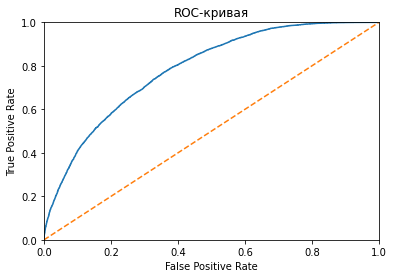

In [156]:
#расчет ROC_AUC через вероятности классов и построение графика ROC - кривой
rock(test_features_oe, test_target_oe, model)

#### Подбор порога классификации для предсказаний

In [157]:
%%time
probabilities_valid = cross_val_predict(model, train_features_oe, train_target_oe, cv=5, method='predict_proba')
probabilities_one_valid = probabilities_valid[:, 1]

CPU times: user 13.4 s, sys: 73.2 ms, total: 13.5 s
Wall time: 13.4 s


In [158]:
for threshold in np.arange(0.2, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(train_target_oe, predicted_valid)
    roc = roc_auc_score(train_target_oe, predicted_valid)
    print('threshold=', round(threshold,3), 'F1=', round(f1,4), 'roc=', round(roc,3))


threshold= 0.2 F1= 0.491 roc= 0.648
threshold= 0.22 F1= 0.4984 roc= 0.658
threshold= 0.24 F1= 0.5062 roc= 0.668
threshold= 0.26 F1= 0.5141 roc= 0.678
threshold= 0.28 F1= 0.5226 roc= 0.687
threshold= 0.3 F1= 0.529 roc= 0.694
threshold= 0.32 F1= 0.5365 roc= 0.702
threshold= 0.34 F1= 0.5438 roc= 0.708
threshold= 0.36 F1= 0.5499 roc= 0.713
threshold= 0.38 F1= 0.5548 roc= 0.716
threshold= 0.4 F1= 0.5597 roc= 0.719
threshold= 0.42 F1= 0.564 roc= 0.721
threshold= 0.44 F1= 0.5679 roc= 0.722
threshold= 0.46 F1= 0.5703 roc= 0.722
threshold= 0.48 F1= 0.5696 roc= 0.719
threshold= 0.5 F1= 0.569 roc= 0.717
threshold= 0.52 F1= 0.568 roc= 0.714
threshold= 0.54 F1= 0.5628 roc= 0.709
threshold= 0.56 F1= 0.556 roc= 0.703
threshold= 0.58 F1= 0.5477 roc= 0.696
threshold= 0.6 F1= 0.538 roc= 0.689
threshold= 0.62 F1= 0.5263 roc= 0.681
threshold= 0.64 F1= 0.5159 roc= 0.675
threshold= 0.66 F1= 0.5037 roc= 0.668
threshold= 0.68 F1= 0.4899 roc= 0.66


При пороге классификации threshold= 0.46 значения f- меры и roc_auc незначительно повышаются.

сильно повышается значения f- меры с 0.574 до 0.604

roc_auc растёт не так сильно, с 0.688 до 0.704



#### Промежуточный вывод

На тестовой выборке модель Случайный Лес имеет roc_auc = 0.784 при расчете через вероятность классов, и roc_auc = 0.704 при расчете через предсказания

<b>Оценка прибыли, 

которую принесёт выбранная модель за год.

In [159]:
hotel_test

,is_canceled,lead_time,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,revenue_hotel
0,1,74.0,0,2.0,0.0,0.0,0.0,93.0,3.0,0,0,0,0.0,0,0,2.0,0,0,1,-1400.0
1,1,62.0,2,2.0,0.0,0.0,0.0,8.0,3.0,0,0,0,0.0,0,0,2.0,0,1,4,-1400.0
2,1,71.0,2,1.0,0.0,0.0,0.0,93.0,3.0,0,0,0,0.0,0,0,2.0,0,1,4,-1400.0
3,1,172.0,5,2.0,0.0,0.0,0.0,10.0,3.0,0,0,0,0.0,0,0,2.0,0,0,7,-1400.0
4,1,52.0,5,1.0,0.0,0.0,0.0,30.0,3.0,0,0,0,0.0,0,0,2.0,0,0,7,-1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24683,0,164.0,4,2.0,0.0,0.0,0.0,30.0,3.0,0,0,0,0.0,0,0,2.0,0,0,6,6800.0
24684,0,21.0,5,2.0,0.0,0.0,0.0,10.0,3.0,0,0,0,0.0,0,0,2.0,0,2,7,8200.0
24685,0,23.0,5,2.0,0.0,0.0,0.0,10.0,3.0,0,0,0,0.0,0,0,2.0,0,0,7,8200.0
24686,0,34.0,5,2.0,0.0,0.0,0.0,30.0,3.0,0,0,0,3.0,0,0,2.0,0,4,7,4790.0


In [160]:
#функция расчета прибыли с учетом работы модели
def revenue_hotel_ml(row):
    
    if row['is_canceled'] == 0:
        # прибыль в случае успешного заселения никак не меняется
        revenue = row['revenue_hotel']
    else:
        revenue = row['revenue_hotel'] #прибыль отрицательная и так же не меняется
        if row['predictions'] == 1: #если совпало целевое значение и предсказание то убыток составляет *0.2
            revenue = revenue * 0.2

    return revenue

In [161]:
#добавляем предсказания модели в тестовый датасет
hotel_test['predictions'] = predictions_tres

In [162]:
#добавляем прибыль в тестовый датасет
hotel_test['revenue_ml'] = hotel_test.apply(revenue_hotel_ml, axis=1)

In [163]:
#проверка правильности работы функции
hotel_test[['is_canceled', 'revenue_hotel', 'predictions', 'revenue_ml']].sample(10)

,is_canceled,revenue_hotel,predictions,revenue_ml
14526,0,2200.0,False,2200.0
16839,0,950.0,False,950.0
7153,1,-1400.0,False,-1400.0
19656,0,2010.0,False,2010.0
157,1,-1400.0,True,-280.0
11444,1,-1800.0,True,-360.0
9962,1,-1400.0,True,-280.0
6931,1,-1400.0,True,-280.0
17177,0,2800.0,False,2800.0
20236,0,2010.0,True,2010.0


Если модель оценила факт отмены брони верно, то такой результат можно использовать как правильный для оценки прибыли за год

Для лучшего результата, буду использовать предсказания `predictions_tres` с подобранным порогом классификации. То есть с порогом threshold= 0.4

In [164]:
#проверка количества нулей и единиц в предсказанных значениях
pd.Series(predictions_tres).value_counts()

False    12418
True     12181
dtype: int64

In [165]:
#проверка количества нулей и единиц в верных значениях
test_target_oe.value_counts()

0    16845
1     7754
Name: is_canceled, dtype: int64

In [166]:
#проверка количества совпадающих единиц
(predictions_tres * test_target_oe).value_counts()

0    18577
1     6022
Name: is_canceled, dtype: int64

In [167]:
#дополнительная проверка количества совпадающих единиц через матрицу ошибок
confusion_matrix(test_target_oe, predictions_tres)

array([[10686,  6159],
       [ 1732,  6022]])

In [168]:
#общее количество строк в предсказаниях и верных ответах
len(test_target_oe), len(predictions_tres)

(24599, 24599)

Тестовый датасет имеет данные как раз за один 2017й год. Значит все значения из него и можно использовать для расчета прибыли после внедрения модели

In [169]:
hotel_test

,is_canceled,lead_time,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,revenue_hotel,predictions,revenue_ml
0,1,74.0,0,2.0,0.0,0.0,0.0,93.0,3.0,0,...,0.0,0,0,2.0,0,0,1,-1400.0,True,-280.0
1,1,62.0,2,2.0,0.0,0.0,0.0,8.0,3.0,0,...,0.0,0,0,2.0,0,1,4,-1400.0,False,-1400.0
2,1,71.0,2,1.0,0.0,0.0,0.0,93.0,3.0,0,...,0.0,0,0,2.0,0,1,4,-1400.0,True,-280.0
3,1,172.0,5,2.0,0.0,0.0,0.0,10.0,3.0,0,...,0.0,0,0,2.0,0,0,7,-1400.0,True,-280.0
4,1,52.0,5,1.0,0.0,0.0,0.0,30.0,3.0,0,...,0.0,0,0,2.0,0,0,7,-1400.0,True,-280.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24683,0,164.0,4,2.0,0.0,0.0,0.0,30.0,3.0,0,...,0.0,0,0,2.0,0,0,6,6800.0,True,6800.0
24684,0,21.0,5,2.0,0.0,0.0,0.0,10.0,3.0,0,...,0.0,0,0,2.0,0,2,7,8200.0,True,8200.0
24685,0,23.0,5,2.0,0.0,0.0,0.0,10.0,3.0,0,...,0.0,0,0,2.0,0,0,7,8200.0,True,8200.0
24686,0,34.0,5,2.0,0.0,0.0,0.0,30.0,3.0,0,...,3.0,0,0,2.0,0,4,7,4790.0,False,4790.0


In [170]:
#расчет прибыли = (прибыль после внедрения модели - прибыль до внедрения) * верные положительные предсказания
revenue_model = (hotel_test['revenue_ml'] - hotel_test['revenue_hotel']) * (predictions_tres * test_target_oe)

In [171]:
revenue_model.sum()

6251888.0

6 251 888 прибыль без учета стоимости разработки. 

Стоимость разработки системы прогнозирования - 400 000.

Отсюда "прибыль которую принесёт модель за год" равна


In [172]:
 revenue_model.sum() - BUDGET_PREDICT

5851888.0

то есть за один год модель принесёт прибыль 5 851 888 (около 5.8 млн )

### Шаг 5. Опишите портрет «ненадёжного» клиента

признак отмены заказа is_canceled. То есть 1 означает что заказ отменен.

Очевидно что "ненадёжные" клиенты это те, кто в большинстве по какому либо параметру.

In [173]:
hotel_train.columns

Index(['is_canceled', 'lead_time', 'stays_in_week_nights', 'adults',
       'children', 'babies', 'meal', 'country', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights', 'revenue_hotel'],
      dtype='object')

In [174]:
list_columns_drop = [
    
    #'id', 
    'lead_time',
    'is_canceled', 
    #'arrival_date_year',
    #'arrival_date_month', 
    #'arrival_date_week_number',
    #'arrival_date_day_of_month', 
    'stays_in_week_nights',
    #'stays_in_week_nights', 
    'total_of_special_requests', 
    'revenue_hotel'
]

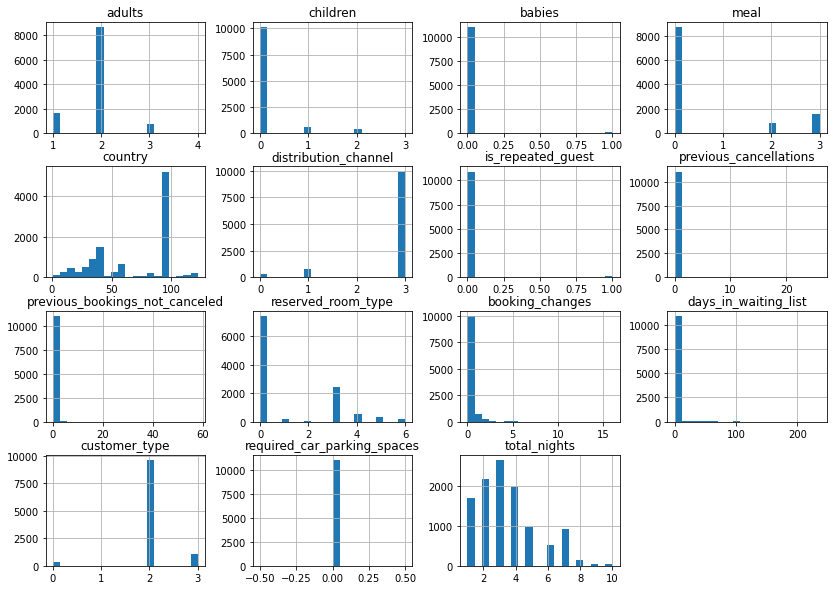

In [175]:
(hotel_train
 .query('is_canceled == 1')
 .drop(list_columns_drop, axis=1)
 .hist(bins=20, figsize=(14,10))
 #.sort_values(by=list_columns, ascending=False)
 #.head(10)
)
None

In [176]:
#выяснение какой стране принадлежит максимальное количество отказов от бронирования
(hotel_train
 .query('is_canceled == 1')
 .country
 .value_counts()
)

93.0     5076
36.0      864
40.0      748
42.0      711
57.0      595
         ... 
119.0       1
75.0        1
102.0       1
99.0        1
92.0        1
Name: country, Length: 100, dtype: int64

In [177]:
bad_client = hotel_train.query('is_canceled == 1 & adults == 2 & children == 0 & babies == 0 & meal == 0 & country == 93 & distribution_channel == 3 & is_repeated_guest == 0 & previous_cancellations == 0 & previous_bookings_not_canceled == 0 & booking_changes == 0 & days_in_waiting_list == 0 & customer_type == 2 & required_car_parking_spaces == 0 & total_nights == [2,3]')

In [178]:
len(bad_client)

545

<b>Ненадёжный клиент это:<b>



    - adults — количество взрослых постояльцев = 2
    - children — количество детей от 3 до 14 лет = 0
    - babies — количество младенцев = 0
    - meal - опции заказа = 0
    - country - гражданство постояльца = 93 (наверное стоит выяснить какой стране присвоил этот номер OrdinalEncoder)
    - distribution_channel - канал дистрибуции заказа = 3 (также выяснить соответствие OrdinalEncoder)
    - is_repeated_guest — признак того, что гость бронирует номер второй раз = 0
    - previous_cancellations — количество отменённых заказов у клиента = 0
    - previous_bookings_not_canceled — количество подтверждённых заказов у клиента = 0
    - booking_changes — количество изменений параметров заказа = 0
    - days_in_waiting_list — сколько дней заказ ожидал подтверждения = 0 (Но это относится не клиенту а к самому отелю)
    - customer_type - тип заказчика = 2 (также выяснить соответствие OrdinalEncoder)
    - required_car_parking_spaces — необходимость места для автомобиля = 0
    - total_nights — общее количество ночей = 2 или 3. Правда есть достаточное количество клиентов с количеством ночей 1 и 4
    
Таких клиентов в таблице `hotel_train`  545, то есть около 1.2% от общего количества (43618 строк).

### Шаг 6. Общий вывод

Наилучшая модель из трёх изученых - Случайный лес. 

Несмотря на её низкую скорость работы эта модель даёт лучшую F1, чем другие.

Название модели | F1   |F1 (test)  |auc-roc(test)|
----------------|------|-----------|-------------|
Дерево          |0.559 |           |             | 
Случайный лес   |0.572 |0.604      |0.784        |
Лог.регрессия   |0.539

Для дальнейшего предсказания поведения клиента, предлагаю использовать модель Случайный лес.

Самые ненадёжныные клиенты имеют следующие характеристики:

- adults — количество взрослых постояльцев = 2
- children — количество детей от 3 до 14 лет = 0
- babies — количество младенцев = 0
- meal - опции заказа = 0
- country - гражданство постояльца = 93
- distribution_channel - канал дистрибуции заказа = 3
- is_repeated_guest — признак того, что гость бронирует номер второй раз = 0
- previous_cancellations — количество отменённых заказов у клиента = 0
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента = 0
- booking_changes — количество изменений параметров заказа = 0
- days_in_waiting_list — сколько дней заказ ожидал подтверждения = 0 (Но это относится не клиенту а к самому отелю)
- customer_type - тип заказчика = 2
- required_car_parking_spaces — необходимость места для автомобиля = 0
- total_nights — общее количество ночей = 2 или 3. Правда есть достаточное количество клиентов с количеством ночей 1 и 4
    
Клиенту, имеющему такие данные, необходимо предложить внести депозит.